# TRABAJO INVESTIGACIÓN


Este es el libro con el código del trabajo de investigación, procedemos a cargar las librerías y datos necesarios.

In [1]:
!pip install tensorflow

In [2]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 40 kB/s 
     |████████████████████████████████| 198 kB 52.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805911 sha256=b4604a95e685b65965ce01ddeb90343f2750083f617af63da6ca7805465ddb30
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [3]:
!pip install keras.utils

  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=451ebd7f4cd69d1c8499578fe7cf43775cd5a9359693412876d351117c8e1215
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras.utils


In [4]:
import tensorflow
import numpy as np
import keras
import time
import pandas as pd
import pyspark
import sklearn

from pyspark.sql import functions as f
from pyspark.sql.types import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.datasets import fashion_mnist
from keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential

El enfoque del trabajo será entrenar una red tipo CNN con el dataset fashion_mnist, después tomar solo las camisetas y entrenar una GAN, por último testear la red con la imagen generada, comprobando su capacidad de generalización.


# Red CNN

In [5]:
#Carga de los datos
(train_x, train_y), (test_x, test_y) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [6]:
#Reshapes y cambios de formato en las target.
x_train = train_x.reshape(60000, 28, 28, 1)
x_test = test_x.reshape(10000, 28, 28, 1)

y_train = to_categorical(train_y, 10)
y_test = to_categorical(test_y, 10)

In [7]:
#Normalizamos 0-1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

Programamos la red neuronal.

In [8]:
num_classes = 10

model = Sequential()

model.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(64, kernel_size=3, activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
          
model.add(Dense(num_classes, activation="softmax"))


In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
start = time.time()
results = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=100, epochs=15)
end = time.time()

print('Training time: {}'.format(end-start))

Epoch 1/15
600/600 [==============================] - 18s 8ms/step - loss: 0.4182 - accuracy: 0.8512 - val_loss: 0.2948 - val_accuracy: 0.8940
Epoch 2/15
600/600 [==============================] - 5s 8ms/step - loss: 0.2662 - accuracy: 0.9019 - val_loss: 0.2497 - val_accuracy: 0.9066
Epoch 3/15
600/600 [==============================] - 5s 8ms/step - loss: 0.2167 - accuracy: 0.9200 - val_loss: 0.2256 - val_accuracy: 0.9187
Epoch 4/15
600/600 [==============================] - 5s 8ms/step - loss: 0.1818 - accuracy: 0.9313 - val_loss: 0.2235 - val_accuracy: 0.9194
Epoch 5/15
600/600 [==============================] - 5s 8ms/step - loss: 0.1517 - accuracy: 0.9441 - val_loss: 0.2190 - val_accuracy: 0.9208
Epoch 6/15
600/600 [==============================] - 5s 8ms/step - loss: 0.1280 - accuracy: 0.9514 - val_loss: 0.2369 - val_accuracy: 0.9169
Epoch 7/15
600/600 [==============================] - 5s 8ms/step - loss: 0.1076 - accuracy: 0.9597 - val_loss: 0.2210 - val_accuracy: 0.9267
Epoch

Gran precisión, visualicemos el proceso.

In [11]:
# list all data in history
print(results.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


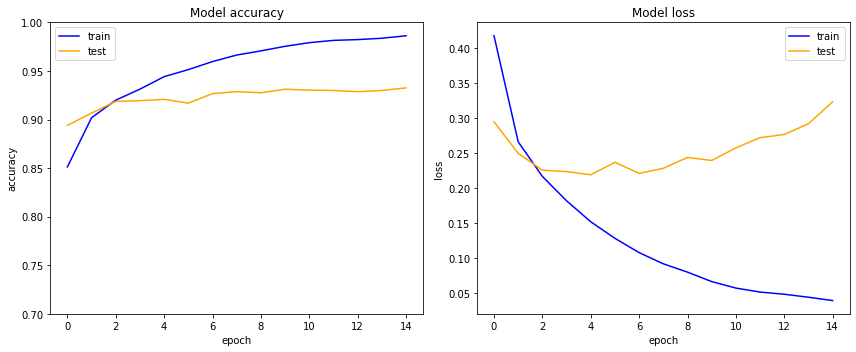

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# summarize history for accuracy
axes[0].plot(results.history['accuracy'], c='blue', label='train')
axes[0].plot(results.history['val_accuracy'], c='orange', label='test')
axes[0].set_title('Model accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('accuracy')
axes[0].set_ylim(0.7,1)
axes[0].legend()

# summarize history for loss
axes[1].plot(results.history['loss'], c='blue', label='train')
axes[1].plot(results.history['val_loss'], c='orange', label='test')
axes[1].set_title('Model loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('loss')
axes[1].legend()

plt.tight_layout()
plt.show()

In [13]:
# Predicción de imágenes de test
print(model.predict(x_test[:4]))
y_test[:4]

[[2.4057012e-16 2.1180238e-17 2.2415232e-15 2.8596867e-16 8.4308333e-14
  2.5593896e-13 1.3537286e-14 6.6128922e-11 3.8032805e-17 1.0000000e+00]
 [1.3761265e-08 3.0742252e-18 1.0000000e+00 2.5216438e-16 5.8404324e-15
  2.0800117e-20 2.5707329e-15 4.2199913e-18 5.1311611e-19 1.1179902e-18]
 [1.7597112e-18 1.0000000e+00 2.4115898e-17 1.4037539e-14 1.7275739e-16
  2.7230222e-17 2.8731487e-15 1.2939039e-22 4.7181530e-13 4.6631241e-20]
 [2.4236251e-17 1.0000000e+00 7.0953258e-19 6.4418787e-14 2.5534031e-16
  1.4582509e-18 2.4760131e-13 5.6444815e-23 3.6452797e-17 1.5223729e-20]]


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [14]:
score = model.evaluate(x_test, y_test)

print('Loss: {}, Accuracy: {}'.format(score[0], score[1]))

313/313 [==============================] - 1s 4ms/step - loss: 0.3235 - accuracy: 0.9326
Loss: 0.3235388398170471, Accuracy: 0.9326000213623047


# Red GAN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [2]:
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [4]:
# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

In [5]:
class GAN(tf.keras.Model):
    """ a basic GAN class 
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        # generating noise from a uniform distribution
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)
        ### losses
        # losses of real with label "1"
        disc_real_loss = gan_loss(logits=logits_x, is_real=True)
        # losses of fake with label "0"
        disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False)
        disc_loss = disc_fake_loss + disc_real_loss

        # losses of fake with label "1"
        gen_loss = gan_loss(logits=logits_x_gen, is_real=True)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )
    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)
        
        
def gan_loss(logits, is_real=True):
    """Computes standard gan loss between logits and labels
    """
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(
        multi_class_labels=labels, logits=logits
    )


In [6]:
N_Z = 64
generator = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

In [7]:
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.005)# train the model
# model
model = GAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z
)

In [8]:
# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

In [9]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

Epoch: 74 | disc_loss: 0.7757696509361267 | gen_loss: 1.3581007719039917


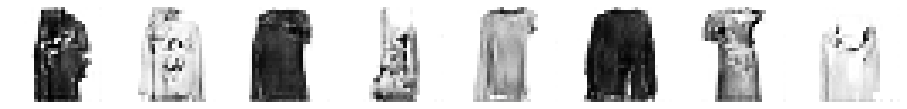

In [10]:
n_epochs = 75
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    plot_reconstruction(model)

No conseguimos la calidad deseada con las redes GAN, se deben estudiar otras vías. Conseguir camisetas diferentes para etiquetar es uno de los objetivos del código, al no ser logrado parece difícil la realización de esta tarea mediante nuestro método, se plantearán líneas de trabajo futuras.